---
## Step 1: Setup and Imports

In [23]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Add parent directory for MAPS import
sys.path.insert(0, '..')

# Clear cached imports
for mod_name in list(sys.modules.keys()):
    if 'MAPS' in mod_name or 'maps' in mod_name:
        del sys.modules[mod_name]

from MAPS.cell_phenotyping import Trainer, Predictor

print("✅ All imports successful!")
print(f"📂 Working directory: {os.getcwd()}")

✅ All imports successful!
📂 Working directory: c:\Users\mahee\OneDrive\Documents\Semester-12\FYDP-2\MAPS\Experiments_my_ideas


---
## Step 2: Load and Explore the Dataset

In [24]:
# Loading the annotation CSV
csv_path = '../cHL_CODEX/annotation_csv/cHL_CODEX_annotation.csv'

print("Loading dataset...")
print(f"📁 Path: {csv_path}")
print(f"📊 File size: {os.path.getsize(csv_path) / (1024**2):.2f} MB\n")

# Load with progress
dataset = pd.read_csv(csv_path)

print(f"✅ Dataset loaded!")
print(f"   Shape: {dataset.shape}")
print(f"   Cells: {dataset.shape[0]:,}")
print(f"   Columns: {dataset.shape[1]}")

Loading dataset...
📁 Path: ../cHL_CODEX/annotation_csv/cHL_CODEX_annotation.csv
📊 File size: 113.78 MB

✅ Dataset loaded!
   Shape: (145161, 54)
   Cells: 145,161
   Columns: 54
✅ Dataset loaded!
   Shape: (145161, 54)
   Cells: 145,161
   Columns: 54


In [25]:
# Display first few rows
print("\n📋 First 5 rows:")
dataset.head()


📋 First 5 rows:


,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,...,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,...,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,...,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,...,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,...,0.052713,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,...,0.026865,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000


In [26]:
# Check column names
print("\n📊 Column Information:")
print(f"\nTotal columns: {len(dataset.columns)}")
print("\nColumns:")
for i, col in enumerate(dataset.columns, 1):
    print(f"{i:2}. {col}")


📊 Column Information:

Total columns: 54

Columns:
 1. cellLabel
 2. X_cent
 3. Y_cent
 4. cellSize
 5. cellType
 6. BCL.2
 7. CCR6
 8. CD11b
 9. CD11c
10. CD15
11. CD16
12. CD162
13. CD163
14. CD2
15. CD20
16. CD206
17. CD25
18. CD30
19. CD31
20. CD4
21. CD44
22. CD45RA
23. CD45RO
24. CD45
25. CD5
26. CD56
27. CD57
28. CD68
29. CD69
30. CD7
31. CD8
32. Collagen.4
33. Cytokeratin
34. DAPI.01
35. EGFR
36. FoxP3
37. Granzyme.B
38. HLA.DR
39. IDO.1
40. LAG.3
41. MCT
42. MMP.9
43. MUC.1
44. PD.1
45. PD.L1
46. Podoplanin
47. T.bet
48. TCR.g.d
49. TCRb
50. Tim.3
51. VISA
52. Vimentin
53. a.SMA
54. b.Catenin



🔬 Cell Type Distribution:
cellType
CD4              37480
CD8              17184
B                16196
DC                9637
Endothelial       8705
Tumor             8260
NK                7339
M2                7286
Monocyte          6913
Other             5108
Lymphatic         3768
Neutrophil        3442
TReg              3352
Mast              3324
M1                3101
Epithelial        2251
Seg Artifact      1431
Cytotoxic CD8      384
Name: count, dtype: int64

📊 Total unique cell types: 18


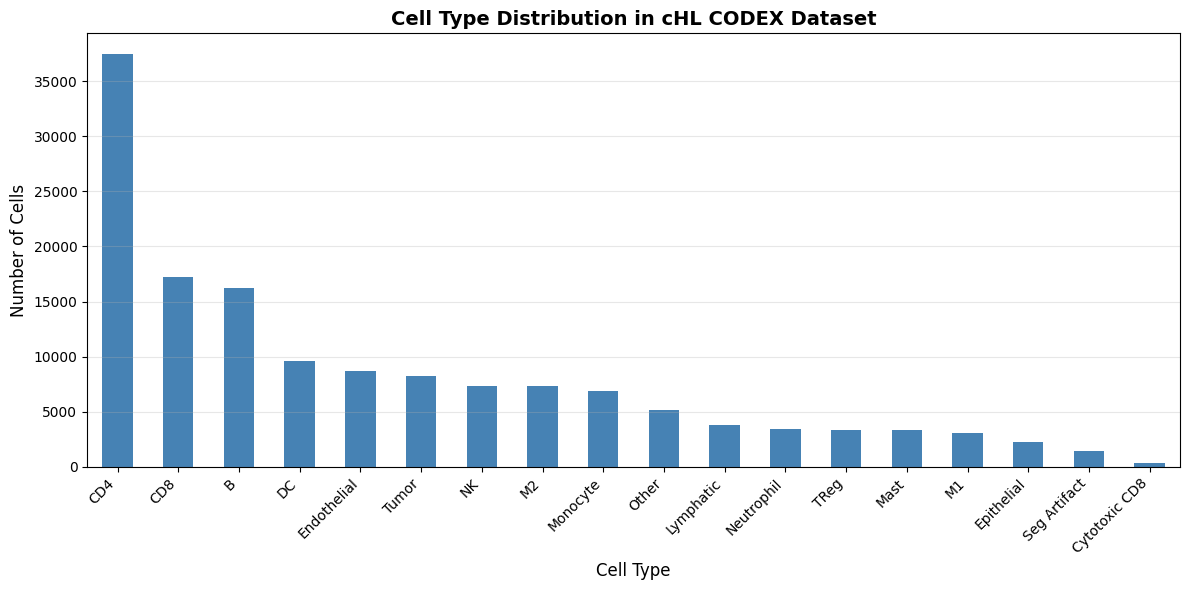

In [27]:
# Check cell types
if 'cellType' in dataset.columns:
    print("\n🔬 Cell Type Distribution:")
    cell_type_counts = dataset['cellType'].value_counts()
    print(cell_type_counts)
    
    print(f"\n📊 Total unique cell types: {len(cell_type_counts)}")
    
    # Visualize
    plt.figure(figsize=(12, 6))
    cell_type_counts.plot(kind='bar', color='steelblue')
    plt.title('Cell Type Distribution in cHL CODEX Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Cell Type', fontsize=12)
    plt.ylabel('Number of Cells', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("⚠️ 'cellType' column not found!")

---
## Step 3: Data Preprocessing

In [28]:
# Cleaning the dataset
print("🧹 Cleaning dataset...")
print(f"   Before: {len(dataset):,} cells")

# Remove segmentation artifacts
if 'Seg Artifact' in dataset['cellType'].values:
    dataset = dataset[dataset['cellType'] != 'Seg Artifact']
    print(f"   Removed 'Seg Artifact' cells")

# Merge similar cell types (if needed)
if 'Cytotoxic CD8' in dataset['cellType'].values:
    dataset.loc[dataset['cellType'] == 'Cytotoxic CD8', 'cellType'] = 'CD8'
    print(f"   Merged 'Cytotoxic CD8' → 'CD8'")

dataset.reset_index(inplace=True, drop=True)

print(f"   After: {len(dataset):,} cells")
print(f"   Unique cell types: {dataset['cellType'].nunique()}")

🧹 Cleaning dataset...
   Before: 145,161 cells
   Removed 'Seg Artifact' cells
   Merged 'Cytotoxic CD8' → 'CD8'
   After: 143,730 cells
   Unique cell types: 16


In [29]:
# Creating class mapping
print("\n🗂️ Creating class mappings...")

class_dict = {'class_id': [], 'class_name': [], 'sample_count': []}
class_mapping = {}

for i, class_name in enumerate(sorted(dataset['cellType'].unique())):
    class_dict['class_id'].append(i)
    class_dict['class_name'].append(class_name)
    class_dict['sample_count'].append(np.sum(dataset['cellType'] == class_name))
    class_mapping[class_name] = i

class_df = pd.DataFrame(class_dict)
print("\nClass Mapping:")
print(class_df.to_string(index=False))

NUM_CLASSES = len(class_mapping)


🗂️ Creating class mappings...

Class Mapping:
 class_id  class_name  sample_count
        0           B         16196
        1         CD4         37480
        2         CD8         17568
        3          DC          9637
        4 Endothelial          8705
        5  Epithelial          2251
        6   Lymphatic          3768
        7          M1          3101
        8          M2          7286
        9        Mast          3324
       10    Monocyte          6913
       11          NK          7339
       12  Neutrophil          3442
       13       Other          5108
       14        TReg          3352
       15       Tumor          8260

Class Mapping:
 class_id  class_name  sample_count
        0           B         16196
        1         CD4         37480
        2         CD8         17568
        3          DC          9637
        4 Endothelial          8705
        5  Epithelial          2251
        6   Lymphatic          3768
        7          M1          3101
 

In [30]:
# Extracting features and labels
print("\n🔧 Extracting features...")

# Identify non-marker columns
non_marker_cols = ['X_cent', 'Y_cent', 'cellLabel', 'cellSize', 'cellType']
marker_names = [col for col in dataset.columns if col not in non_marker_cols]
marker_names = sorted(marker_names)

print(f"\n📊 Protein Markers: {len(marker_names)}")
print("\nMarker list:")
for i, marker in enumerate(marker_names, 1):
    print(f"  {i:2}. {marker}")

NUM_FEATURES = len(marker_names) + 1  # markers + cellSize


🔧 Extracting features...

📊 Protein Markers: 49

Marker list:
   1. BCL.2
   2. CCR6
   3. CD11b
   4. CD11c
   5. CD15
   6. CD16
   7. CD162
   8. CD163
   9. CD2
  10. CD20
  11. CD206
  12. CD25
  13. CD30
  14. CD31
  15. CD4
  16. CD44
  17. CD45
  18. CD45RA
  19. CD45RO
  20. CD5
  21. CD56
  22. CD57
  23. CD68
  24. CD69
  25. CD7
  26. CD8
  27. Collagen.4
  28. Cytokeratin
  29. DAPI.01
  30. EGFR
  31. FoxP3
  32. Granzyme.B
  33. HLA.DR
  34. IDO.1
  35. LAG.3
  36. MCT
  37. MMP.9
  38. MUC.1
  39. PD.1
  40. PD.L1
  41. Podoplanin
  42. T.bet
  43. TCR.g.d
  44. TCRb
  45. Tim.3
  46. VISA
  47. Vimentin
  48. a.SMA
  49. b.Catenin


In [31]:
# Preparing feature matrix
print("\n🎯 Preparing feature matrix and labels...")

features_cols = marker_names + ['cellSize']
features = dataset[features_cols].copy()
labels = np.array([class_mapping[class_name] for class_name in dataset['cellType']])
features['cell_label'] = labels

print(f"   Features shape: {features.shape}")
print(f"   Labels shape: {labels.shape}")
print(f"   Label range: {labels.min()} to {labels.max()}")


🎯 Preparing feature matrix and labels...
   Features shape: (143730, 51)
   Labels shape: (143730,)
   Label range: 0 to 15
   Features shape: (143730, 51)
   Labels shape: (143730,)
   Label range: 0 to 15


---
## Step 4: Make Train/Valid Splits

In [32]:
# Creating stratified split (80/20)
print("\n📂 Creating train/validation splits...")

# Create output directory
output_dir = './cHL_CODEX_processed'
os.makedirs(output_dir, exist_ok=True)

# Stratified split
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(features.to_numpy()[:, :-1], labels))

train_split = features.iloc[train_index]
valid_split = features.iloc[valid_index]

# Save splits
train_path = os.path.join(output_dir, 'train.csv')
valid_path = os.path.join(output_dir, 'valid.csv')

train_split.to_csv(train_path, index=False)
valid_split.to_csv(valid_path, index=False)

print(f"\n✅ Splits created!")
print(f"   Training set: {len(train_split):,} cells ({len(train_split)/len(features)*100:.1f}%)")
print(f"   Validation set: {len(valid_split):,} cells ({len(valid_split)/len(features)*100:.1f}%)")
print(f"\n📁 Saved to:")
print(f"   Train: {train_path}")
print(f"   Valid: {valid_path}")

# Save class mapping
class_df.to_csv(os.path.join(output_dir, 'class_names.csv'), index=False)
print(f"   Classes: {os.path.join(output_dir, 'class_names.csv')}")


📂 Creating train/validation splits...

✅ Splits created!
   Training set: 114,984 cells (80.0%)
   Validation set: 28,746 cells (20.0%)

📁 Saved to:
   Train: ./cHL_CODEX_processed\train.csv
   Valid: ./cHL_CODEX_processed\valid.csv
   Classes: ./cHL_CODEX_processed\class_names.csv

✅ Splits created!
   Training set: 114,984 cells (80.0%)
   Validation set: 28,746 cells (20.0%)

📁 Saved to:
   Train: ./cHL_CODEX_processed\train.csv
   Valid: ./cHL_CODEX_processed\valid.csv
   Classes: ./cHL_CODEX_processed\class_names.csv


In [33]:
# Verify class distribution in splits
print("\n📊 Verifying class distribution:")

train_labels = train_split['cell_label'].value_counts().sort_index()
valid_labels = valid_split['cell_label'].value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Class': class_df['class_name'].values,
    'Train': [train_labels.get(i, 0) for i in range(NUM_CLASSES)],
    'Valid': [valid_labels.get(i, 0) for i in range(NUM_CLASSES)]
})
comparison_df['Train %'] = (comparison_df['Train'] / comparison_df['Train'].sum() * 100).round(2)
comparison_df['Valid %'] = (comparison_df['Valid'] / comparison_df['Valid'].sum() * 100).round(2)

print(comparison_df.to_string(index=False))


📊 Verifying class distribution:
      Class  Train  Valid  Train %  Valid %
          B  12956   3240    11.27    11.27
        CD4  29984   7496    26.08    26.08
        CD8  14054   3514    12.22    12.22
         DC   7710   1927     6.71     6.70
Endothelial   6964   1741     6.06     6.06
 Epithelial   1801    450     1.57     1.57
  Lymphatic   3014    754     2.62     2.62
         M1   2481    620     2.16     2.16
         M2   5829   1457     5.07     5.07
       Mast   2659    665     2.31     2.31
   Monocyte   5531   1382     4.81     4.81
         NK   5871   1468     5.11     5.11
 Neutrophil   2754    688     2.40     2.39
      Other   4087   1021     3.55     3.55
       TReg   2681    671     2.33     2.33
      Tumor   6608   1652     5.75     5.75


---
## Step 5: Train New Model


In [34]:
# Checking if my GPU is detected
import torch

print("🖥️ Hardware Check:")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
else:
    print("   Running on CPU")

🖥️ Hardware Check:
   CUDA available: True
   GPU: NVIDIA GeForce GTX 1650
   CUDA version: 12.1


In [ ]:
# Initializing trainer
print("\n🚀 Initializing trainer...")

results_dir = './results_new_model/'
os.makedirs(results_dir, exist_ok=True)

trainer = Trainer(
    results_dir=results_dir,
    num_features=NUM_FEATURES,
    num_classes=NUM_CLASSES,
    batch_size=512 if torch.cuda.is_available() else 128,
    learning_rate=0.001,
    dropout=0.10,
    max_epochs=100,
    min_epochs=20,
    patience=20,
    num_workers=4 if torch.cuda.is_available() else 0,
    seed=42,
    verbose=1
)

print("\n✅ Trainer initialized!")
print(f"   Device: {trainer.device}")
print(f"   Batch size: {trainer.batch_size}")
print(f"   Max epochs: {trainer.max_epochs}")
print(f"   Patience: {trainer.patience}")


🚀 Initializing trainer...

✅ Trainer initialized!
   Device: cuda
   Batch size: 512
   Max epochs: 100
   Patience: 20


In [36]:
# Training the model
print("\n" + "="*60)
print("TRAINING NEW MODEL")
print("="*60)

start_time = time.time()

trainer.fit(train_path, valid_path)

training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"\n⏱️  Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


TRAINING NEW MODEL
Training Batch 224/224, avg loss: 2.1898
Confusion Matrix
          class_0  class_1  class_2  class_3  class_4  class_5  class_6  \
class_0      1056      469      696      347       39      310      333   
class_1       623      571      741      239       78      180      264   
class_2       423      383     1337      117       36      395      401   
class_3       267      118      270      837      181       96      219   
class_4        41        6      204       69     2825       77      335   
class_5       159       99      677      110      308      656     1328   
class_6       162       70      374      116      416      427     1936   
class_7       218       79      294      428      539      177      520   
class_8       182       39      248      289      863      132      373   
class_9        69       74      548       72       28      196      275   
class_10       92       13      185      497      331       42      114   
class_11       17     

---
## Step 6: Visualizing the Training Progress

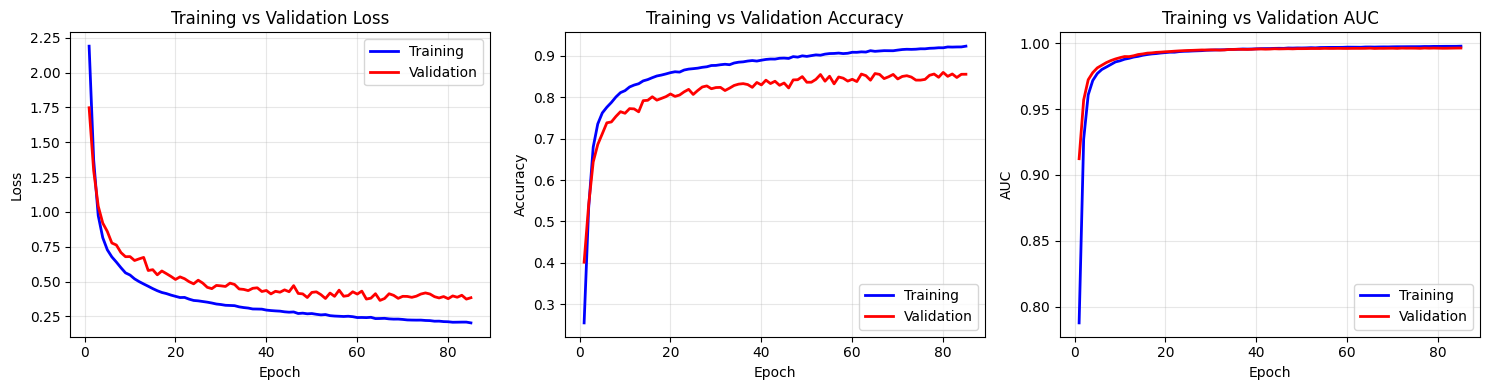


📊 TRAINING SUMMARY:
   Epochs completed: 85
   Best validation loss: 0.3654 (epoch 65)
   Best validation accuracy: 0.8603 (epoch 80)
   Final validation AUC: 0.9963
   Time per epoch: 68.01 seconds


In [37]:
# Load training logs
logs_path = os.path.join(results_dir, 'training_logs.csv')

if os.path.exists(logs_path):
    logs = pd.read_csv(logs_path)
    epochs = range(1, len(logs) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(epochs, logs['train_loss'], 'b-', label='Training', linewidth=2)
    axes[0].plot(epochs, logs['valid_loss'], 'r-', label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training vs Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, logs['train_acc'], 'b-', label='Training', linewidth=2)
    axes[1].plot(epochs, logs['valid_acc'], 'r-', label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training vs Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # AUC
    axes[2].plot(epochs, logs['train_auc'], 'b-', label='Training', linewidth=2)
    axes[2].plot(epochs, logs['valid_auc'], 'r-', label='Validation', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].set_title('Training vs Validation AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n📊 TRAINING SUMMARY:")
    print(f"   Epochs completed: {len(logs)}")
    print(f"   Best validation loss: {logs['valid_loss'].min():.4f} (epoch {logs['valid_loss'].idxmin() + 1})")
    print(f"   Best validation accuracy: {logs['valid_acc'].max():.4f} (epoch {logs['valid_acc'].idxmax() + 1})")
    print(f"   Final validation AUC: {logs['valid_auc'].iloc[-1]:.4f}")
    print(f"   Time per epoch: {training_time/len(logs):.2f} seconds")

---
## Step 7: Evaluating New Model

In [38]:
# Make predictions with new model
print("🔮 Making predictions with new model...")
pred_labels_new, pred_probs_new = trainer.predict(valid_path)

# Load ground truth
gt_labels = valid_split['cell_label'].to_numpy()

# Calculate accuracy
accuracy_new = accuracy_score(gt_labels, pred_labels_new)

print(f"\n🎯 NEW MODEL ACCURACY: {accuracy_new:.4f} ({accuracy_new*100:.2f}%)")

🔮 Making predictions with new model...
Batch 57/57            
🎯 NEW MODEL ACCURACY: 0.8576 (85.76%)

🎯 NEW MODEL ACCURACY: 0.8576 (85.76%)


In [39]:
# Detailed classification report
print("\n📋 CLASSIFICATION REPORT (New Model):")
print("="*70)
print(classification_report(gt_labels, pred_labels_new, 
                          target_names=class_df['class_name'].tolist(), 
                          digits=3))


📋 CLASSIFICATION REPORT (New Model):
              precision    recall  f1-score   support

           B      0.896     0.851     0.873      3240
         CD4      0.934     0.769     0.843      7496
         CD8      0.913     0.917     0.915      3514
          DC      0.780     0.851     0.814      1927
 Endothelial      0.894     0.933     0.913      1741
  Epithelial      0.753     0.922     0.829       450
   Lymphatic      0.835     0.958     0.892       754
          M1      0.634     0.884     0.738       620
          M2      0.820     0.852     0.836      1457
        Mast      0.928     0.967     0.947       665
    Monocyte      0.787     0.819     0.803      1382
          NK      0.902     0.856     0.878      1468
  Neutrophil      0.778     0.952     0.856       688
       Other      0.806     0.887     0.845      1021
        TReg      0.537     0.861     0.661       671
       Tumor      0.918     0.936     0.927      1652

    accuracy                          0.85

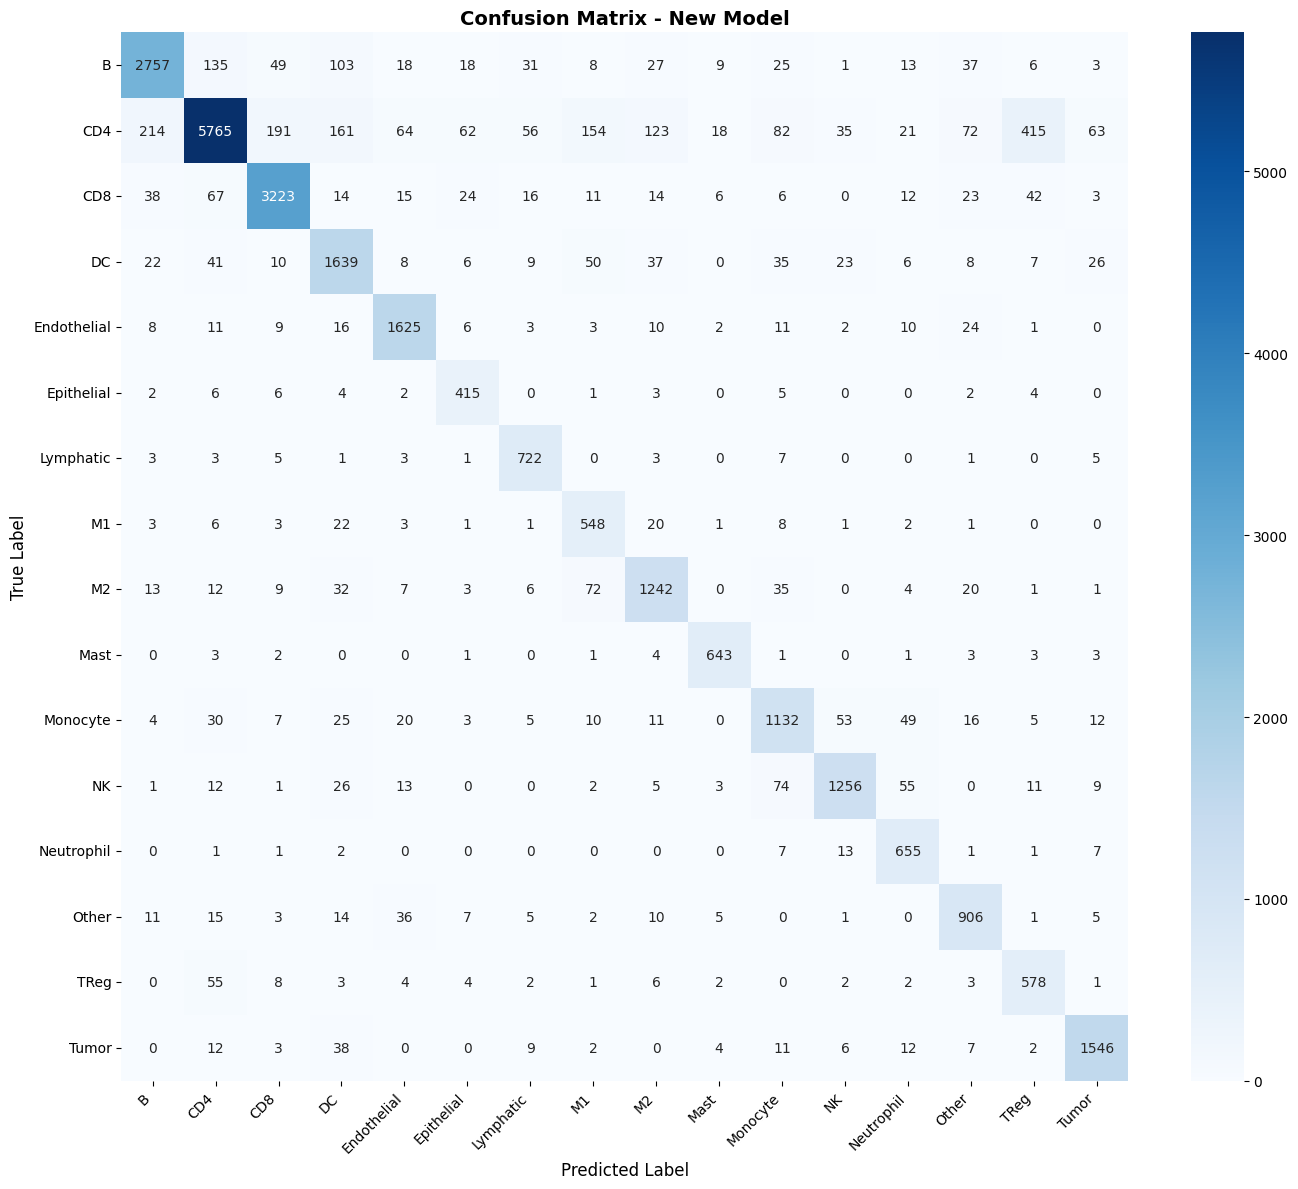

In [40]:
# Confusion matrix
cm_new = confusion_matrix(gt_labels, pred_labels_new)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_df['class_name'].tolist(),
            yticklabels=class_df['class_name'].tolist())
plt.title('Confusion Matrix - New Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## Step 8: Compare with MAPS Pretrained Model

In [41]:
# Load pretrained MAPS model
pretrained_path = '../models/cell_phenotyping/cHL_CODEX.pt'

if os.path.exists(pretrained_path):
    print("📦 Loading MAPS pretrained model...")
    
    pretrained_predictor = Predictor(
        model_checkpoint_path=pretrained_path,
        num_features=NUM_FEATURES,
        num_classes=NUM_CLASSES,
        batch_size=512 if torch.cuda.is_available() else 128
    )
    
    print("🔮 Making predictions with pretrained model...")
    pred_labels_pretrained, pred_probs_pretrained = pretrained_predictor.predict(valid_path)
    
    accuracy_pretrained = accuracy_score(gt_labels, pred_labels_pretrained)
    
    print(f"\n🎯 PRETRAINED MODEL ACCURACY: {accuracy_pretrained:.4f} ({accuracy_pretrained*100:.2f}%)")
    
else:
    print(f"⚠️ Pretrained model not found at {pretrained_path}")
    print("   Skipping comparison...")
    accuracy_pretrained = None
    pred_labels_pretrained = None

📦 Loading MAPS pretrained model...
🔮 Making predictions with pretrained model...
Batch 57/57            
🎯 PRETRAINED MODEL ACCURACY: 0.9080 (90.80%)

🎯 PRETRAINED MODEL ACCURACY: 0.9080 (90.80%)


In [42]:
# Detailed comparison
if accuracy_pretrained is not None:
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    print(f"\n📊 New Model (trained by you):       {accuracy_new:.4f} ({accuracy_new*100:.2f}%)")
    print(f"📊 MAPS Pretrained Model:            {accuracy_pretrained:.4f} ({accuracy_pretrained*100:.2f}%)")
    print(f"\n📈 Difference: {(accuracy_new - accuracy_pretrained)*100:+.2f}%")
    
    if accuracy_new > accuracy_pretrained:
        print("\n🎉 Congratulations! Your model performs better!")
    elif accuracy_new > accuracy_pretrained - 0.02:
        print("\n✅ Great! Your model performs comparably!")
    else:
        print("\n💡 The pretrained model was trained for more epochs (500 vs 100).")


MODEL COMPARISON

📊 New Model (trained by you):       0.8576 (85.76%)
📊 MAPS Pretrained Model:            0.9080 (90.80%)

📈 Difference: -5.04%

💡 The pretrained model was trained for more epochs (500 vs 100).



📊 PER-CLASS COMPARISON:
      Class  Count  New Model F1  Pretrained F1  Difference
       Mast    665         0.947          0.955      -0.008
        CD8   3514         0.915          0.936      -0.021
          B   3240         0.873          0.903      -0.030
      Other   1021         0.845          0.876      -0.031
Endothelial   1741         0.913          0.945      -0.032
      Tumor   1652         0.927          0.966      -0.039
        CD4   7496         0.843          0.886      -0.042
  Lymphatic    754         0.892          0.949      -0.057
         NK   1468         0.878          0.939      -0.061
         M2   1457         0.836          0.907      -0.072
 Epithelial    450         0.829          0.902      -0.073
         DC   1927         0.814          0.894      -0.080
   Monocyte   1382         0.803          0.897      -0.095
 Neutrophil    688         0.856          0.952      -0.095
       TReg    671         0.661          0.761      -0.100
         M1    

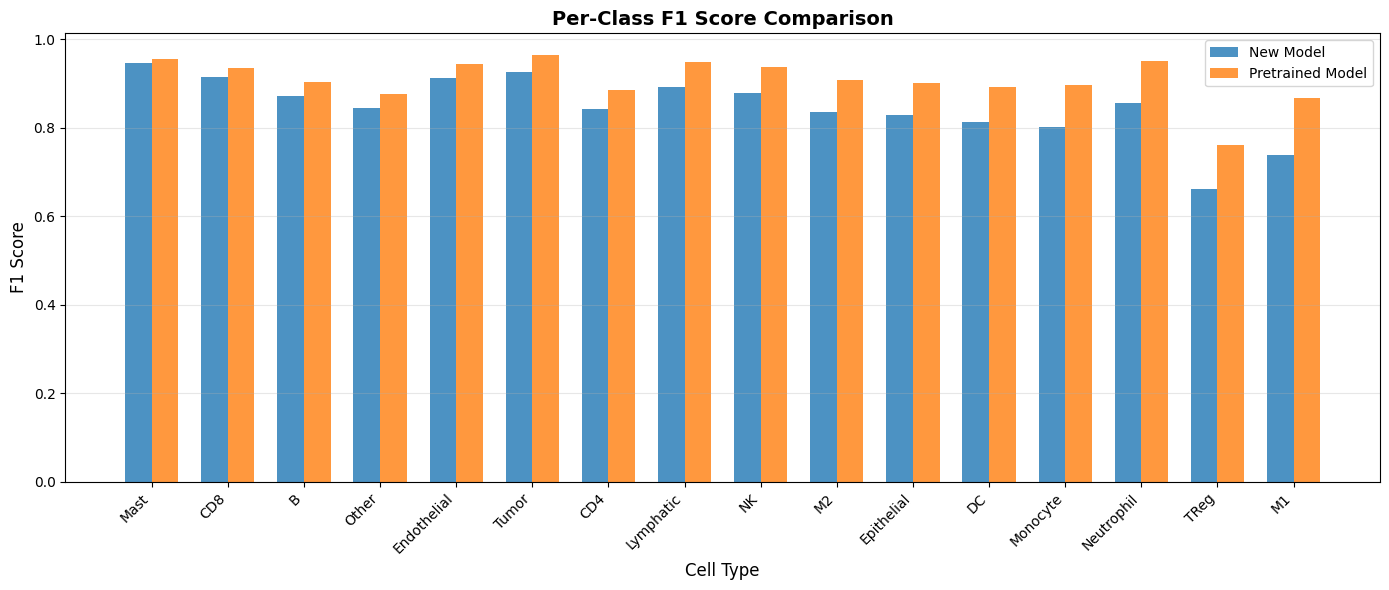

In [43]:
# Per-class comparison
if accuracy_pretrained is not None:
    print("\n📊 PER-CLASS COMPARISON:")
    print("="*90)
    
    from sklearn.metrics import f1_score, precision_score, recall_score
    
    comparison_data = []
    for i, class_name in enumerate(class_df['class_name']):
        # Get binary labels for this class
        gt_binary = (gt_labels == i).astype(int)
        pred_new_binary = (pred_labels_new == i).astype(int)
        pred_pre_binary = (pred_labels_pretrained == i).astype(int)
        
        # Calculate metrics
        f1_new = f1_score(gt_binary, pred_new_binary, zero_division=0)
        f1_pre = f1_score(gt_binary, pred_pre_binary, zero_division=0)
        
        comparison_data.append({
            'Class': class_name,
            'Count': (gt_labels == i).sum(),
            'New Model F1': f1_new,
            'Pretrained F1': f1_pre,
            'Difference': f1_new - f1_pre
        })
    
    comp_df = pd.DataFrame(comparison_data)
    comp_df = comp_df.sort_values('Difference', ascending=False)
    
    print(comp_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    
    # Visualize
    plt.figure(figsize=(14, 6))
    x = np.arange(len(comp_df))
    width = 0.35
    
    plt.bar(x - width/2, comp_df['New Model F1'], width, label='New Model', alpha=0.8)
    plt.bar(x + width/2, comp_df['Pretrained F1'], width, label='Pretrained Model', alpha=0.8)
    
    plt.xlabel('Cell Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Per-Class F1 Score Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x, comp_df['Class'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## Step 9: Final Summary & Next Steps

In [44]:
print("\n" + "="*70)
print("🏁 EXPERIMENT SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Total cells: {len(dataset):,}")
print(f"   Cell types: {NUM_CLASSES}")
print(f"   Features: {NUM_FEATURES}")
print(f"   Training cells: {len(train_split):,}")
print(f"   Validation cells: {len(valid_split):,}")

print(f"\n⏱️  Training:")
print(f"   Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"   Epochs completed: {len(logs) if 'logs' in locals() else 'N/A'}")
print(f"   Device: {trainer.device}")

print(f"\n🎯 Performance:")
print(f"   New Model: {accuracy_new:.4f} ({accuracy_new*100:.2f}%)")
if accuracy_pretrained is not None:
    print(f"   Pretrained Model: {accuracy_pretrained:.4f} ({accuracy_pretrained*100:.2f}%)")
    print(f"   Difference: {(accuracy_new - accuracy_pretrained)*100:+.2f}%")

print(f"\n💾 Saved Files:")
print(f"   Model: {os.path.join(results_dir, 'best_checkpoint.pt')}")
print(f"   Logs: {logs_path}")
print(f"   Data: {output_dir}")

print("\n✅ Experiment complete!")


🏁 EXPERIMENT SUMMARY

📊 Dataset:
   Total cells: 143,730
   Cell types: 16
   Features: 50
   Training cells: 114,984
   Validation cells: 28,746

⏱️  Training:
   Total time: 5781.00 seconds (96.35 minutes)
   Epochs completed: 85
   Device: cuda

🎯 Performance:
   New Model: 0.8576 (85.76%)
   Pretrained Model: 0.9080 (90.80%)
   Difference: -5.04%

💾 Saved Files:
   Model: ./results_new_model/best_checkpoint.pt
   Logs: ./results_new_model/training_logs.csv
   Data: ./cHL_CODEX_processed

✅ Experiment complete!
